# CSV to JSON-LD via Morph

ref: https://github.com/morph-kgc/morph-kgc/tree/main/examples 

## Imports

In [1]:
import morph_kgc
import pandas as pd
import pygwalker as pyg
import json
import jbutils
import io
import pyoxigraph
from pygraphml import GraphMLParser
from pygraphml import Graph as GraphML
from hashlib import sha256
import networkx as nx
from ipysigma import Sigma

## Load Florida Data 

In [2]:
df = pd.read_csv("../inputs/GDSC_metadata.csv")

In [3]:
print(df.columns.values)

['ID' 'Title' 'Creator' 'Url' 'DOI' 'Publisher' 'Rights' 'License'
 'Restrictions' 'Coverage' 'Relations' 'Type' 'Date' 'Description'
 'Provenance' 'Subject' 'Language' 'Structure' 'Geometry' 'Bands'
 'Pixel Dimension' 'EPSG' 'Scale' 'Extent' 'Lineage' 'Process Step'
 'Processor' 'Point of Contact' 'Data Level' 'Label' 'Values' 'Attributes'
 'Color Ramp' 'Tile Zoom Levels' 'Collections' 'Analytic Function'
 'Analytic EPSG' 'Thumbnail' 'Service Definition' 'Sponsor' 'Status'
 'Rights Statement' 'Disclaimer' 'Service' 'Source' 'Parameters'
 'File Name' 'Extension' 'Download' 'Table Name' 'Format' 'Dependency'
 'Custom ETL' 'Custom Parameters' 'up' 'podID' 'Index Fields' 'Bash ETL'
 'SQL Transform' 'Last Updated' 'Update Frequency' 'Last Accessed'
 'Columns' 'ETL Documentation' 'Notes' 'TODO']


In [4]:
# NOTE:  this can be problematic with your install of jupyterlab, it does work in DataSpell, but my Jupyter lab errors out. 
# This is just a "nice to have" but  not needed.  See:  https://kanaries.net/pygwalker
# It is for visualization of numeric values not so much qa/qc on text literals.  
# walker = pyg.walk(df)

In [5]:
df.head(5)

,ID,Title,Creator,Url,DOI,Publisher,Rights,License,Restrictions,Coverage,...,Index Fields,Bash ETL,SQL Transform,Last Updated,Update Frequency,Last Accessed,Columns,ETL Documentation,Notes,TODO
0,1,Miami-Dade Home Owner's Loan Corporation (HOLC...,University of Richmond's Digital Scholarship Lab,https://services.arcgis.com/jIL9msH9OI208GCb/a...,NaN,University of Richmond's Digital Scholarship Lab,Public Domain,NaN,Use items owned by Esri in ArcGIS Online in co...,United States,...,--,TBD,TBD,2021-08-17,Never,--,OBJECTID|HOLC_grade|city|HOLC|Code|ST |CitySta...,Direct download as ESRI json from ESRI service...,NaN,update to reflect Miami only\ninclude other ci...
1,2,2019 Florida Census Tracts,Department of Commerce|U.S. Census Bureau|Geog...,https://www.census.gov/geographies/mapping-fil...,NaN,Department of Commerce|U.S. Census Bureau|Geog...,Public Domain,This Software was created by U.S. Government e...,NaN,United States|Florida,...,--,TBD,TBD,2021-09-22,Never,--,"STATEFP(string,2)|COUNTYFP(string,3)|TRACTCE(s...",ogr2ogr shapefile to postGIS,NaN,NaN
2,3,2019 Miami-Dade ACS 5 Year Estimates - Tract L...,Department of Commerce|U.S. Census Bureau,https://www.census.gov/data/developers/data-se...,NaN,Department of Commerce|U.S. Census Bureau,Public Domain,This Software was created by U.S. Government e...,NaN,United States|Florida,...,--,TBD,TBD,2021-06-02,Never,--,https://api.census.gov/data/2019/acs/acs5/vari...,The custom function acs_customgregate is given...,please use this as a template for all ACS esti...,NaN
3,4,2019 Florida ACS 5 Year Estimates - Tract Leve...,Department of Commerce|U.S. Census Bureau,https://www.census.gov/data/developers/data-se...,NaN,Department of Commerce|U.S. Census Bureau,Public Domain,This Software was created by U.S. Government e...,NaN,United States|Florida,...,--,TBD,TBD,2022-11-22,Never,--,https://api.census.gov/data/2019/acs/acs5/vari...,The custom function acs_customgregate is given...,update using 2019 DVMT ACS as model,NaN
4,5,2020 Florida Census Tracts - Florida,Department of Commerce|U.S. Census Bureau|Geog...,https://www.census.gov/geographies/mapping-fil...,NaN,Department of Commerce|U.S. Census Bureau|Geog...,Public Domain,This Software was created by U.S. Government e...,NaN,United States|Florida,...,--,TBD,TBD,2021-09-22,Never,--,"STATEFP(string,2)|COUNTYFP(string,3)|TRACTCE(s...",ogr2ogr shapefile to postGIS,NaN,NaN


In [6]:
# split serializations
df['Coverage'] = df['Coverage'].map(lambda x: x if pd.isnull(x) == True else x.split('|'))

In [7]:
unique_counts = df['Coverage'].value_counts()
print(unique_counts)

Coverage
[United States, Florida, Miami Dade County]    31
[United States, Florida]                       17
[Miami-Dade County]                            17
[United States]                                14
[Southeast]                                     5
[Florida]                                       5
[Trinidad and Tobago]                           4
[Miami-Dade County, Florida]                    3
[Colombia, Bogota]                              3
[--]                                            2
[Global]                                        1
[United States, Florida, Miami-Dade County]     1
[City of Miami]                                 1
[USA]                                           1
Name: count, dtype: int64


## Test Mapping on 1 row

In [8]:
df1 = df.head(2)

In [9]:
df1.head()

,ID,Title,Creator,Url,DOI,Publisher,Rights,License,Restrictions,Coverage,...,Index Fields,Bash ETL,SQL Transform,Last Updated,Update Frequency,Last Accessed,Columns,ETL Documentation,Notes,TODO
0,1,Miami-Dade Home Owner's Loan Corporation (HOLC...,University of Richmond's Digital Scholarship Lab,https://services.arcgis.com/jIL9msH9OI208GCb/a...,NaN,University of Richmond's Digital Scholarship Lab,Public Domain,NaN,Use items owned by Esri in ArcGIS Online in co...,[United States],...,--,TBD,TBD,2021-08-17,Never,--,OBJECTID|HOLC_grade|city|HOLC|Code|ST |CitySta...,Direct download as ESRI json from ESRI service...,NaN,update to reflect Miami only\ninclude other ci...
1,2,2019 Florida Census Tracts,Department of Commerce|U.S. Census Bureau|Geog...,https://www.census.gov/geographies/mapping-fil...,NaN,Department of Commerce|U.S. Census Bureau|Geog...,Public Domain,This Software was created by U.S. Government e...,NaN,"[United States, Florida]",...,--,TBD,TBD,2021-09-22,Never,--,"STATEFP(string,2)|COUNTYFP(string,3)|TRACTCE(s...",ogr2ogr shapefile to postGIS,NaN,NaN


In [10]:
%%capture
data_dict = {"variable1": df1}

config = """
    [DataSource]
    mappings=./florida.ttl
"""

g_rdflib = morph_kgc.materialize(config, data_dict)
ts = g_rdflib.serialize(format="json-ld")

In [11]:
g_rdflib

<Graph identifier=Nae86c362919143c28f73e1d187c80f4a (<class 'rdflib.graph.Graph'>)>

### View results

We can load this to https://validator.schema.org or https://json-ld.org/playground


In [12]:
from pyld import jsonld
context = {
    "name": "https://schema.org/name"
}

# compact a document according to a particular context
# see: https://json-ld.org/spec/latest/json-ld/#compacted-document-form
compacted = jsonld.compact(json.loads(ts), context)

In [13]:
print(json.dumps(compacted,indent=2))

{
  "@context": {
    "name": "https://schema.org/name"
  },
  "@graph": [
    {
      "@id": "http://example.com/ns#1",
      "@type": "https://schema.org/Dataset",
      "name": "Miami-Dade Home Owner's Loan Corporation (HOLC) Neighborhood Redlining Grade",
      "https://schema.org/publisher": {
        "@type": "http://www.w3.org/2000/01/rdf-schema#Literal",
        "@value": "University of Richmond's Digital Scholarship Lab Public Domain"
      },
      "https://schema.org/spatialCoverage": {
        "@id": "https://example.org/.well-known/genid/1"
      }
    },
    {
      "@id": "http://example.com/ns#2",
      "@type": "https://schema.org/Dataset",
      "name": "2019 Florida Census Tracts",
      "https://schema.org/publisher": {
        "@type": "http://www.w3.org/2000/01/rdf-schema#Literal",
        "@value": "Department of Commerce|U.S. Census Bureau|Geography Division|Spatial Data Collection and Products Branch Public Domain"
      },
      "https://schema.org/spatialCove

In [64]:
print(ts)

[
  {
    "@id": "http://example.com/ns#56.0",
    "@type": [
      "https://schema.org/Dataset"
    ],
    "https://schema.org/name": [
      {
        "@value": "2015 Miami-Dade County DEM 30ft "
      }
    ],
    "https://schema.org/publisher": [
      {
        "@type": "http://www.w3.org/2000/01/rdf-schema#Literal",
        "@value": "University of Miami GDSC Public Domain"
      }
    ],
    "https://schema.org/spatialCoverage": [
      {
        "@id": "https://example.org/.well-known/genid/56.0"
      }
    ]
  },
  {
    "@id": "http://example.com/ns#87.0",
    "@type": [
      "https://schema.org/Dataset"
    ],
    "https://schema.org/name": [
      {
        "@value": "NLCD 2021 Land Cover (CONUS)"
      }
    ],
    "https://schema.org/publisher": [
      {
        "@type": "http://www.w3.org/2000/01/rdf-schema#Literal",
        "@value": "Multi-Resolution Land Characteristics Consortium, U.S. Geological Survey, Sioux Falls, SD Public Domain"
      }
    ],
    "https://s

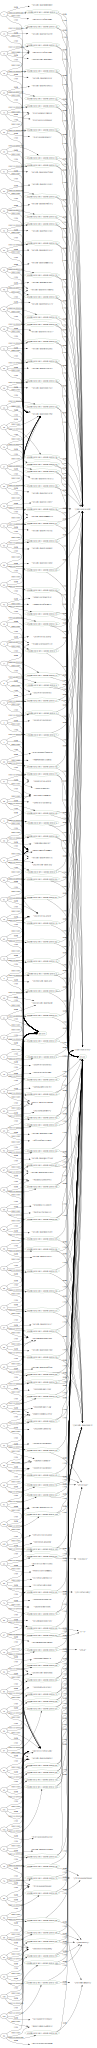

In [46]:
tsld = json.loads(ts)
jbutils.show_graph(tsld)

## Process full graph

Once we are happy with the mapping we can loop all the records and load them into an inprocess triplestore

loop the df and load the ntriples into oxigraph and query


In [13]:
# store = pyoxigraph.Store()  #    store = pyoxigraph.Store(path="./store") # use path for disk store
diskstore = pyoxigraph.Store(path="./store2")
mime_type = "application/n-triples"   # application/n-triples or application/n-quads if you are loading those from data raw

In [14]:
config = """
    [DataSource]
    mappings=./florida.ttl
"""

# # Loop through rows using iterrows
# for index, row in df.iterrows():
#     print(f"Index: {index}, Name: {row['Name']}, Age: {row['Age']}")

data_dict = {"variable1": df}
    
g_rdflib = morph_kgc.materialize(config, data_dict)
ts2 = g_rdflib.serialize(format="nt")
    
diskstore.bulk_load(io.StringIO(ts2), mime_type, base_iri=None, to_graph=None)

In [15]:
qtypetype = """	PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <https://schema.org/>

SELECT DISTINCT ?source ?type ?target ?sType ?tType ?coverage
WHERE {
    ?source a ?sType .
    ?target a ?tType .
    ?target schema:name ?coverage .
    ?source ?type ?target .
}
"""

q2 = list(diskstore.query(qtypetype))

In [16]:
dfq = pd.DataFrame(q2)

In [17]:
dfq.rename(columns={0: 'source', 1: 'type', 2:  'target', 3: 'sType', 4: 'tType', 5 : "coverage"}, inplace=True)

In [18]:
dfq.head(5)

,source,type,target,sType,tType,coverage
0,<http://example.com/ns#8.0>,<https://schema.org/spatialCoverage>,<https://example.org/.well-known/genid/8.0>,<https://schema.org/Dataset>,<https://schema.org/Place>,"""United States|Florida""^^<http://www.w3.org/20..."
1,<http://example.com/ns#22.0>,<https://schema.org/spatialCoverage>,<https://example.org/.well-known/genid/22.0>,<https://schema.org/Dataset>,<https://schema.org/Place>,"""United States|Florida|Miami Dade County""^^<ht..."
2,<http://example.com/ns#75.0>,<https://schema.org/spatialCoverage>,<https://example.org/.well-known/genid/75.0>,<https://schema.org/Dataset>,<https://schema.org/Place>,"""United States""^^<http://www.w3.org/2000/01/rd..."
3,<http://example.com/ns#28.0>,<https://schema.org/spatialCoverage>,<https://example.org/.well-known/genid/28.0>,<https://schema.org/Dataset>,<https://schema.org/Place>,"""United States|Florida|Miami Dade County""^^<ht..."
4,<http://example.com/ns#81.0>,<https://schema.org/spatialCoverage>,<https://example.org/.well-known/genid/81.0>,<https://schema.org/Dataset>,<https://schema.org/Place>,"""United States|Florida""^^<http://www.w3.org/20..."


In [19]:
#  yeah, I get it...   don't iterate rows...  PR's welcome for this, being bad is too easy!  
# for index, row in nodes.iterrows():
#    g.add_node(row['Id'])
g = GraphML()
g.directed = False

for index, row in dfq.iterrows():
    n1 = g.add_node(row['source'])
    n1['type'] = row['sType']

    n2 = g.add_node(row['coverage'])
    n2['type'] = row['tType']

    e1 = g.add_edge(n1, n2)
    e1['type'] = row['type']


fname = "testGraphML_hashed.graphml"
parser = GraphMLParser()
parser.write(g, fname)

In [20]:
g = nx.read_graphml("testGraphML_hashed.graphml")

In [21]:
Sigma(
    g,
    node_size=g.degree,
    default_edge_type='curve',
    node_border_color_from='node',
    node_metrics=['louvain'],
    node_color='type',
    start_layout=5,
    edge_size=lambda u, v: g.degree(u) + g.degree(v),
    edge_size_range=(0.5, 5),
    label_font='cursive',
    node_label_size=g.degree,
    label_density=0
)

Sigma(nx.Graph with 118 nodes and 104 edges)

In [22]:
from typing import Union, Any

def custom_node_color_mapping(node: dict[str, Any]):
    """let the color be orange or blue if the index is even or odd respectively"""
    return ("#eb4934" if node['properties']['type'] == "Dataset" else "#2456d4")

In [23]:
from yfiles_jupyter_graphs import GraphWidget

w = GraphWidget(graph=g)
w.set_sidebar(enabled=False)
w.set_node_color_mapping(custom_node_color_mapping)

display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))